In [1]:
#!pip install pandas # Using Jupyter Notebook in Vbox
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB 

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("NYC_Bicycle_Counts_2016_Corrected_2.csv", thousands=',')
df.head()

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,1-Apr,Friday,78.1,66.0,0.01,1704,3126,4115,2552,11497
1,2-Apr,Saturday,55.0,48.9,0.15,827,1646,2565,1884,6922
2,3-Apr,Sunday,39.9,34.0,0.09,526,1232,1695,1306,4759
3,4-Apr,Monday,44.1,33.1,0.47 (S),521,1067,1440,1307,4335
4,5-Apr,Tuesday,42.1,26.1,0,1416,2617,3081,2357,9471


# Clean the Data

In [3]:
#Fix Precipitation Values
remove_parenthesis = lambda item: re.sub(r'([A-Za-z0-9.]*)( \([\w\d]*\))', r'\1', str(item))
df['Precipitation'] = df['Precipitation'].apply(remove_parenthesis)

remove_T = lambda item: re.sub(r'T', '0', str(item))
df['Precipitation'] = df['Precipitation'].apply(remove_T)

# Convert data to floats
df["High Temp (°F)"] = df["High Temp (°F)"].astype(float)
df["Low Temp (°F)"] = df["Low Temp (°F)"].astype(float)
df["Precipitation"] = df["Precipitation"].astype(float)
df["Brooklyn Bridge"] = df["Brooklyn Bridge"].astype(float)
df["Manhattan Bridge"] = df["Manhattan Bridge"].astype(float)
df["Williamsburg Bridge"] = df["Williamsburg Bridge"].astype(float)
df["Queensboro Bridge"] = df["Queensboro Bridge"].astype(float)
df["Total"] = df["Total"].astype(float)

#Remove time from Date and Day columns
remove_time = lambda item: re.sub(r'([0-9-]+)([ 0-9:]*)', r'\1', str(item))
df['Date'] = df['Date'].apply(remove_time)
df['Day'] = df['Day'].apply(remove_time)

# Functions

In [4]:
def normalize_data(split_type, x, mean, std):
    if(split_type == 'train'):
        mean = []
        std = []
        
        for col in range(len(x[0])):
            mean.append(np.mean(x[:, col]))
            std.append(np.std(x[:, col]))
            
        vals = []
        for row in range(len(x)):
            norm_score = []
            
            for col in range(len(x[0])):
                norm_score.append((x[row, col] - mean[col]) / std[col])
            vals.append(norm_score)
            
        vals = np.array(vals)
        
        return vals, mean, std
    
    elif(split_type == 'test'):
        vals = []
        for row in range(len(x)):
            temp = []
            
            for col in range(len(x[0])):
                temp.append((x[row, col] - mean[col]) / std[col])
            
            vals.append(temp)
        
        vals = np.array(vals)
        
        return vals
  
    else:
        print("Wrong Split Type Entered")


In [5]:
def plot_graphs(df, columns, target):
    colors = ['blue', 'green', 'red', 'black']
    
    for i in range(len(columns)):
        df.plot(kind = 'scatter', x = columns[i], y = target, color = colors[i], label = columns[i])
            
    plt.show()

In [6]:
def linear_model(x_train, x_test, y_train, y_test):
    model = LinearRegression()
    model.fit(x_train, y_train)
    
    coeff = model.coef_
    intercept = model.intercept_
    
    yHat = model.predict(x_test)
    mse = np.mean((yHat - y_test) ** 2)
    r2 = r2_score(y_test, yHat)
    
    return yHat, coeff, intercept, mse, r2

In [7]:
def polynomial_model(x_train, x_test, y_train, y_test, d):
    poly = PolynomialFeatures(degree = d)
    poly_x_train = poly.fit_transform(x_train)
    
    model = LinearRegression()
    model.fit(poly_x_train, y_train)
    
    coeff = model.coef_
    intercept = model.intercept_
    
    poly_x_test = poly.fit_transform(x_test)
    yHat = model.predict(poly_x_test)
    
    mse = np.mean((yHat - y_test) ** 2)
    r2 = r2_score(y_test, yHat)
    
    return yHat, coeff, intercept, mse, r2

In [8]:
def ridge_model(x_train, x_test, y_train, y_test, d):
    lambda_values = np.logspace(start=-1.00, stop=2.00, endpoint=True, base=10, num=100)
    
    if(d > 1):
        poly = PolynomialFeatures(degree = d)
        x_train = poly.fit_transform(x_train)
        x_test = poly.fit_transform(x_test)
    
    model_list = []
    r2_values = []
    
    for l in lambda_values:
        model = Ridge(alpha = l, fit_intercept = True)
        model.fit(x_train, y_train)
        
        coeff = model.coef_
        intercept = model.intercept_
                
        yHat = model.predict(x_test)
        r2 = r2_score(y_test, yHat)
        
        model_list.append(model)
        r2_values.append(r2)
        
    max_ind = r2_values.index(max(r2_values))
    best_lambda = lambda_values[max_ind]
    best_r2 = r2_values[max_ind]
    best_model = model_list[max_ind]
    
    yHat = best_model.predict(x_test)
    mse = np.mean((yHat - y_test) ** 2)

    
    plt.plot(lambda_values, r2_values, 'r-')
    plt.xlabel("Lambda Values")
    plt.ylabel("R2 Value")
    plt.title("Plot of R2 score against lambda values")
    plt.show()
    
    return r2, mse, best_lambda

In [9]:
def logistic_regression(x_train, x_test, y_train, y_test):
    model = LogisticRegression()
    model.fit(x_train, y_train)
    
    yHat = model.predict(x_test)
    
    accuracy = metrics.accuracy_score(y_test, yHat)
    
    plt.plot(x_test, y_test, 'bo')
    plt.plot(x_test, yHat, 'r*')
    
    plt.show()
            
    return accuracy, mse, r2

In [10]:
def support_vector_machine(x_train, x_test, y_train, y_test):
    types = ['linear', 'rbf','sigmoid']
    f1_acc = np.zeros((len(types)))
    
    for i in range(len(types)):
        model = svm.SVC(kernel = types[i])
        model.fit(x_train, y_train)
        yHat = model.predict(x_test)
        f1_acc[i] = metrics.f1_score(y_test, yHat, average = 'weighted')

    print('The accuracy for the svm model is :', str(f1_acc.max()), 'with kernel type being', types[f1_acc.argmax()])

In [11]:
def bernoulliModel(xTrain, xTest, yTrain, yTest):
    model = BernoulliNB()
    model.fit(xTrain, yTrain)
    yHat = model.predict(xTest)
    
    accuracy = metrics.accuracy_score(yTest, yHat)
    
    return accuracy

# Question 1

### Total Average Traffic

In [12]:
# Getting Average Traffic of Each Bridge
avgTraffic_Brooklyn = sum(df["Brooklyn Bridge"])/len(df["Brooklyn Bridge"])
avgTraffic_Manhattan = sum(df["Manhattan Bridge"])/len(df["Manhattan Bridge"])
avgTraffic_William = sum(df["Williamsburg Bridge"])/len(df["Williamsburg Bridge"])
avgTraffic_Queen = sum(df["Queensboro Bridge"])/len(df["Queensboro Bridge"])

rndTraffic_Brooklyn = int(round(avgTraffic_Brooklyn))
rndTraffic_Manhattan = int(round(avgTraffic_Manhattan))
rndTraffic_William = int(round(avgTraffic_William))
rndTraffic_Queen = int(round(avgTraffic_Queen)) 

# Print Average Traffic of Each Bridge
print('')
print('Brooklyn Bridge Weekday Average Traffic: ' + str(rndTraffic_Brooklyn) + ' Bikes')
print('Manhattan Bridge Weekday Average Traffic: ' + str(rndTraffic_Manhattan) + ' Bikes')
print('Williamsburg Bridge Weekday Average Traffic: ' + str(rndTraffic_William) + ' Bikes')
print('Queensboro Bridge Weekday Average Traffic: ' + str(rndTraffic_Queen) + ' Bikes')
print('')


Brooklyn Bridge Weekday Average Traffic: 3031 Bikes
Manhattan Bridge Weekday Average Traffic: 5052 Bikes
Williamsburg Bridge Weekday Average Traffic: 6161 Bikes
Queensboro Bridge Weekday Average Traffic: 4301 Bikes



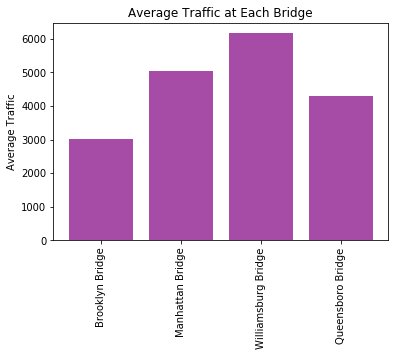

In [13]:
bridges = ('Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge')
xAxis = np.arange(len(bridges))
avgTraffic = [avgTraffic_Brooklyn, avgTraffic_Manhattan, avgTraffic_William, avgTraffic_Queen]

plt.bar(xAxis, avgTraffic, align='center', alpha = 0.7, color = 'purple')
plt.xticks(xAxis, bridges)
plt.ylabel('Average Traffic')
plt.title('Average Traffic at Each Bridge')
plt.xticks(rotation = 90)

plt.show()

In [14]:
weekend = pd.concat([df[df["Day"] == 'Saturday'], df[df["Day"] == 'Sunday']])
weekdays = pd.concat([df[df["Day"] == 'Monday'], df[df["Day"] == 'Tuesday'], df[df["Day"] == 'Wednesday'], df[df["Day"] == 'Thursday'], df[df["Day"] == 'Friday']])

weekendMean = np.mean(weekend['Total'].values)
weekdayMean = np.mean(weekdays['Total'].values)

weekendRnd = int(round(weekendMean))
weekdayRnd = int(round(weekdayMean))

print("Weekend Average: " + str(weekendRnd))
print("Weekday Average: " + str(weekdayRnd))


Weekend Average: 14359
Weekday Average: 20252


### Weekday Average Traffic

In [15]:
# Weekday
avgWeekday_brooklyn = sum(weekdays["Brooklyn Bridge"])/len(weekdays["Brooklyn Bridge"])
avgWeekday_manhattan = sum(weekdays["Manhattan Bridge"])/len(weekdays["Manhattan Bridge"])
avgWeekday_william = sum(weekdays["Williamsburg Bridge"])/len(weekdays["Williamsburg Bridge"])
avgWeekday_queen = sum(weekdays["Queensboro Bridge"])/len(weekdays["Queensboro Bridge"])

rndWeekday_Brook = int(round(avgWeekday_brooklyn))
rndWeekday_Manhattan = int(round(avgWeekday_manhattan))
rndWeekday_William = int(round(avgWeekday_william))
rndWeekday_Queen = int(round(avgWeekday_queen)) 

# Print Average Weekday Traffic of Each Bridge
print('')
print('Brooklyn Bridge Average Weekday Traffic: ' + str(rndWeekday_Brook) + ' Bikes')
print('Manhattan Bridge Average Weekday Traffic: ' + str(rndWeekday_Manhattan) + ' Bikes')
print('Williamsburg Bridge Average Weekday Traffic: ' + str(rndWeekday_William) + ' Bikes')
print('Queensboro Bridge Average Weekday Traffic: ' + str(rndWeekday_Queen) + ' Bikes')
print('')


Brooklyn Bridge Average Weekday Traffic: 3233 Bikes
Manhattan Bridge Average Weekday Traffic: 5515 Bikes
Williamsburg Bridge Average Weekday Traffic: 6803 Bikes
Queensboro Bridge Average Weekday Traffic: 4701 Bikes



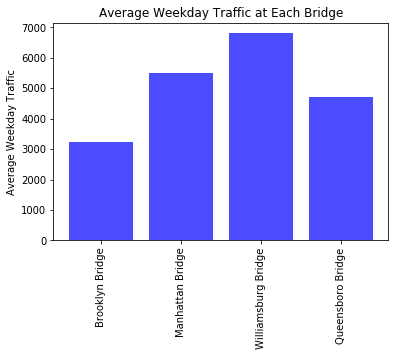

In [16]:
bridge = ('Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge')
x_pos = np.arange(len(bridge))
traffic = [rndWeekday_Brook, rndWeekday_Manhattan, rndWeekday_William, rndWeekday_Queen]

plt.bar(x_pos, traffic, align='center', alpha = 0.7, color = 'blue')
plt.xticks(x_pos, bridge)
plt.ylabel('Average Weekday Traffic')
plt.title('Average Weekday Traffic at Each Bridge')
plt.xticks(rotation = 90)

plt.show()

In [17]:
# Weekend
avgWeekend_brooklyn = sum(weekend["Brooklyn Bridge"])/len(weekend["Brooklyn Bridge"])
avgWeekend_manhattan = sum(weekend["Manhattan Bridge"])/len(weekend["Manhattan Bridge"])
avgWeekend_william = sum(weekend["Williamsburg Bridge"])/len(weekend["Williamsburg Bridge"])
avgWeekend_queen = sum(weekend["Queensboro Bridge"])/len(weekend["Queensboro Bridge"])

rndWeekend_Brook = int(round(avgWeekend_brooklyn))
rndWeekend_Manhattan = int(round(avgWeekend_manhattan))
rndWeekend_William = int(round(avgWeekend_william))
rndWeekend_Queen = int(round(avgWeekend_queen)) 

# Print Average Weekend Traffic of Each Bridge
print('')
print('Brooklyn Bridge Average Weekend Traffic: ' + str(rndWeekend_Brook) + ' Bikes')
print('Manhattan Bridge Average WeekendTraffic: ' + str(rndWeekend_Manhattan) + ' Bikes')
print('Williamsburg Bridge Average Weekend Traffic: ' + str(rndWeekend_William) + ' Bikes')
print('Queensboro Bridge Average Weekend Traffic: ' + str(rndWeekend_Queen) + ' Bikes')
print('')


Brooklyn Bridge Average Weekend Traffic: 2534 Bikes
Manhattan Bridge Average WeekendTraffic: 3917 Bikes
Williamsburg Bridge Average Weekend Traffic: 4587 Bikes
Queensboro Bridge Average Weekend Traffic: 3320 Bikes



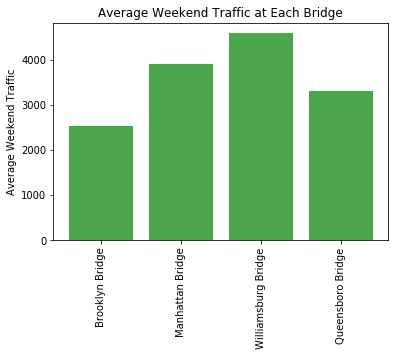

In [18]:
bridge = ('Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge')
x_pos = np.arange(len(bridge))
traffic = [rndWeekend_Brook, rndWeekend_Manhattan, rndWeekend_William, rndWeekend_Queen]

plt.bar(x_pos, traffic, align='center', alpha = 0.7, color = 'green')
plt.xticks(x_pos, bridge)
plt.ylabel('Average Weekend Traffic')
plt.title('Average Weekend Traffic at Each Bridge')
plt.xticks(rotation = 90)

plt.show()

# Question 2

### Verify Independent Variables

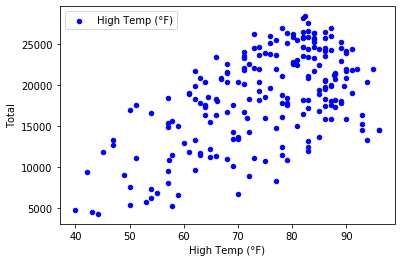

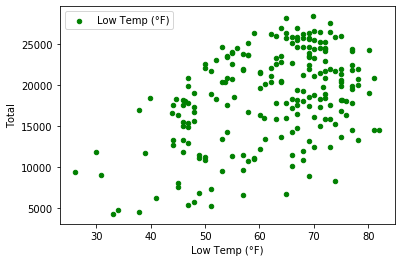

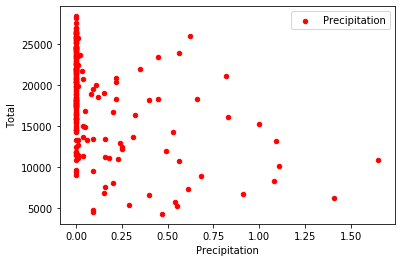

In [19]:
plot_graphs(df, ['High Temp (°F)', 'Low Temp (°F)', 'Precipitation'], 'Total')

### Get Necessary Independent and Target Values

In [20]:
x_values = df[['High Temp (°F)', 'Low Temp (°F)', 'Precipitation']].values
y_values = df[['Total']].values

### Split the Data into Training and Testing

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size = 0.2, random_state = 42)

### Normalize the DataFrame

In [22]:
(norm_train_x, mean_x, std_x) = normalize_data('train', x_train, 0, 0)
norm_test_x = normalize_data('test', x_test, mean_x, std_x)

### Linear Model

In [23]:
(yHat, coeff, intercept, mse, r2) = linear_model(norm_train_x, norm_test_x, y_train, y_test)

print("Mean Squared Error is %.2f" % mse)
print("R2 score is %.2f" % r2)

Mean Squared Error is 17498379.32
R2 score is 0.58


### Quadratic Model

In [24]:
yHat, coeff, intercept, mse, r2 = polynomial_model(norm_train_x, norm_test_x, y_train, y_test, 2)

print("Mean Squared Error is %.2f" % mse)
print("R2 score is %.2f" % r2)

Mean Squared Error is 17049458.16
R2 score is 0.59


### Cubic Model

In [25]:
yHat, coeff, intercept, mse, r2 = polynomial_model(norm_train_x, norm_test_x, y_train, y_test, 3)

print("Mean Squared Error is %.2f" % mse)
print("R2 score is %.2f" % r2)

Mean Squared Error is 103610650.74
R2 score is -1.52


### Linear Ridge Regression

Linear Regression


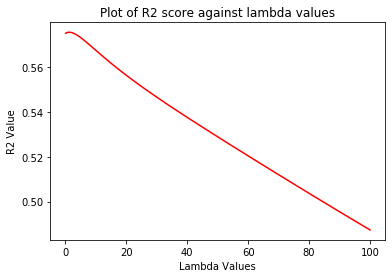

Mean Squared Error is 17476450.30
R2 score is 0.49
Best Lambda is 1.23


In [26]:
print("Linear Regression")
(r2, mse, best_lambda) = ridge_model(norm_train_x, norm_test_x, y_train, y_test, 1)
print("Mean Squared Error is %.2f" % mse)
print("R2 score is %.2f" % r2)
print("Best Lambda is %.2f" % best_lambda)

### Quadratic Ridge Regression

Quadratic Regression


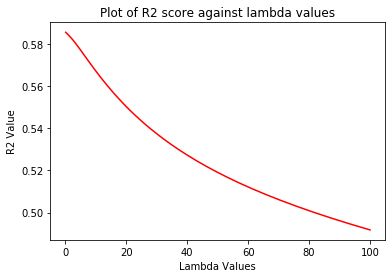

Mean Squared Error is 17056507.13
R2 score is 0.49
Best Lambda is 0.10


In [27]:
print("Quadratic Regression")
(r2, mse, best_lambda) = ridge_model(norm_train_x, norm_test_x, y_train, y_test, 2)
print("Mean Squared Error is %.2f" % mse)
print("R2 score is %.2f" % r2)
print("Best Lambda is %.2f" % best_lambda)

### Cubic Ridge Regression

Cubic Regression


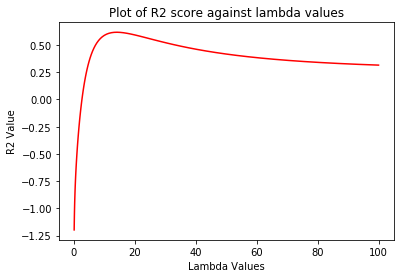

Mean Squared Error is 15758031.68
R2 score is 0.32
Best Lambda is 14.17


In [28]:
print("Cubic Regression")
(r2, mse, best_lambda) = ridge_model(norm_train_x, norm_test_x, y_train, y_test, 3)
print("Mean Squared Error is %.2f" % mse)
print("R2 score is %.2f" % r2)
print("Best Lambda is %.2f" % best_lambda)

# Question 3

### Get Necessary Independent and Target Values

In [29]:
xValues = df[['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge']].to_numpy()
yValues = df[['Precipitation']].to_numpy()

### Verify the Independent Variables

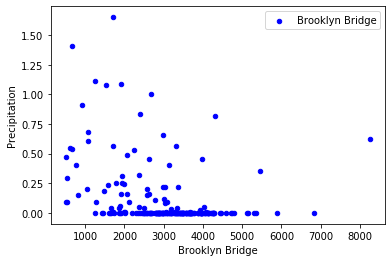

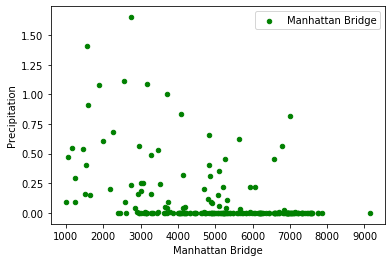

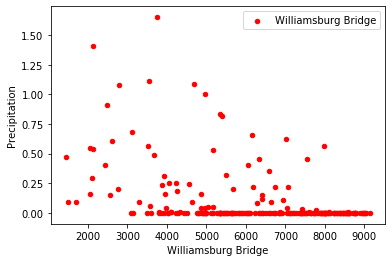

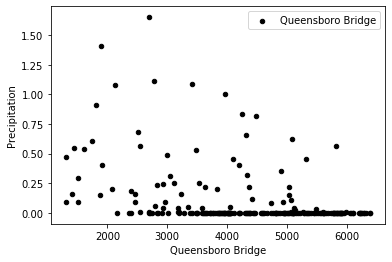

In [30]:
plot_graphs(df, ['Brooklyn Bridge', 'Manhattan Bridge', 'Williamsburg Bridge', 'Queensboro Bridge'], 'Precipitation')

### Boolean Values for When it Rains or Not

In [31]:
for i in range(len(yValues)):
    if(yValues[i][0] > 0.2):
        yValues[i][0] = 1
    else:
        yValues[i][0] = 0

### Plot of Total Cyclists vs Boolean Values of Rain

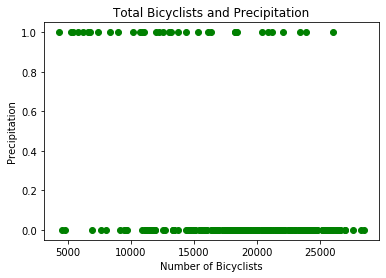

In [32]:
plt.plot(df['Total'], yValues, 'go')
plt.xlabel('Number of Bicyclists')
plt.ylabel('Precipitation')
plt.title('Total Bicyclists and Precipitation')
plt.show()

### Split the Data into Training and Test

In [33]:
xTrain, xTest, yTrain, yTest = train_test_split(xValues, yValues, test_size = 0.2, random_state = 42)

### Normalize the DataFrame

In [34]:
(normXtrain, meanX, stdX) = normalize_data('train', xTrain, 0, 0)
normXtest = normalize_data('test', xTest, meanX, stdX)

### Logistic Regression

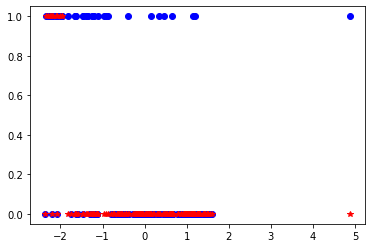

The accuracy of the logistic regression is 0.86


In [35]:
accuracy, mse, r2 = logistic_regression(normXtrain, normXtest, yTrain, yTest)

print("The accuracy of the logistic regression is %.2f" % accuracy)

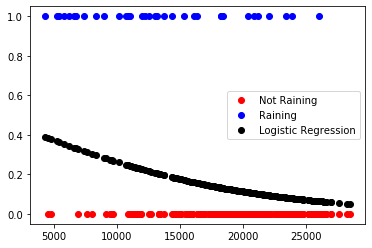

In [36]:
Y = df[['Precipitation']].values
X = df[['Total']].values

index_0 = []
index_1 = []

for i in range(len(yValues)):
    if(yValues[i] == 0):
        index_0.append(i)
    
    elif(yValues[i] == 1):
        index_1.append(i)

model = LogisticRegression()
model.fit(X, yValues)
    
yHat_prob = model.predict_proba(X)[:, 1]

plt.plot(X[index_0], yValues[index_0], 'ro', label = 'Not Raining')
plt.plot(X[index_1], yValues[index_1], 'bo', label = 'Raining')
plt.plot(X, yHat_prob, 'ko', label = 'Logistic Regression')

plt.legend()
plt.show()

### Naive Bayes

In [37]:
accuracy = bernoulliModel(normXtrain, normXtest, yTrain, yTest)
print("The accuracy of the Naive Bayes model is " + str(accuracy))

The accuracy of the Naive Bayes model is 0.7441860465116279


### Support Vector Machine

In [38]:
support_vector_machine(normXtrain, normXtest, yTrain, yTest)

The accuracy for the svm model is : 0.6982784657203261 with kernel type being linear
